In [2]:
import os
import shutil
from itertools import islice
import requests

import pandas as pd
import matplotlib.pyplot as plt

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *

# Create spark_session
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

spark.version

'3.1.3'

In [3]:
!hadoop fs -ls "gs://msca-bdp-amazon/amazon_reviews/"

Found 46 items
-rwx------   3 root root 1971061630 2020-10-28 20:26 gs://msca-bdp-amazon/amazon_reviews/amazon_reviews_us_Apparel_v1_00.tsv
-rwx------   3 root root 1350294084 2020-10-28 20:26 gs://msca-bdp-amazon/amazon_reviews/amazon_reviews_us_Automotive_v1_00.tsv
-rwx------   3 root root  872274720 2020-10-28 20:26 gs://msca-bdp-amazon/amazon_reviews/amazon_reviews_us_Baby_v1_00.tsv
-rwx------   3 root root 2152186111 2020-10-28 20:27 gs://msca-bdp-amazon/amazon_reviews/amazon_reviews_us_Beauty_v1_00.tsv
-rwx------   3 root root 6699171766 2020-10-28 20:29 gs://msca-bdp-amazon/amazon_reviews/amazon_reviews_us_Books_v1_00.tsv
-rwx------   3 root root 6703921864 2020-10-28 20:31 gs://msca-bdp-amazon/amazon_reviews/amazon_reviews_us_Books_v1_01.tsv
-rwx------   3 root root 3238702530 2020-10-28 20:32 gs://msca-bdp-amazon/amazon_reviews/amazon_reviews_us_Books_v1_02.tsv
-rwx------   3 root root 1100169988 2020-10-28 20:32 gs://msca-bdp-amazon/amazon_reviews/amazon_reviews_us_Camera_v1_

In [4]:
from google.cloud import storage
import pandas as pd

In [5]:
# List all files in given COS directory
def list_blobs_pd(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    blob_name = []
    blob_size = []
    
    for blob in blobs:
        blob_name.append(blob.name)
    
    return blob_name

In [6]:
dir_src = "amazon_reviews"
bucket_read = "msca-bdp-amazon"
list_files = list_blobs_pd(bucket_read, dir_src)

In [7]:
for i in range(1, len(list_files)): 
    print(list_files[i])

amazon_reviews/amazon_reviews_us_Apparel_v1_00.tsv
amazon_reviews/amazon_reviews_us_Automotive_v1_00.tsv
amazon_reviews/amazon_reviews_us_Baby_v1_00.tsv
amazon_reviews/amazon_reviews_us_Beauty_v1_00.tsv
amazon_reviews/amazon_reviews_us_Books_v1_00.tsv
amazon_reviews/amazon_reviews_us_Books_v1_01.tsv
amazon_reviews/amazon_reviews_us_Books_v1_02.tsv
amazon_reviews/amazon_reviews_us_Camera_v1_00.tsv
amazon_reviews/amazon_reviews_us_Digital_Ebook_Purchase_v1_00.tsv
amazon_reviews/amazon_reviews_us_Digital_Ebook_Purchase_v1_01.tsv
amazon_reviews/amazon_reviews_us_Digital_Music_Purchase_v1_00.tsv
amazon_reviews/amazon_reviews_us_Digital_Software_v1_00.tsv
amazon_reviews/amazon_reviews_us_Digital_Video_Download_v1_00.tsv
amazon_reviews/amazon_reviews_us_Digital_Video_Games_v1_00.tsv
amazon_reviews/amazon_reviews_us_Electronics_v1_00.tsv
amazon_reviews/amazon_reviews_us_Furniture_v1_00.tsv
amazon_reviews/amazon_reviews_us_Gift_Card_v1_00.tsv
amazon_reviews/amazon_reviews_us_Grocery_v1_00.tsv
a

In [8]:
# Reading data from open bucket, avaible to all students
bucket_read = 'msca-bdp-data-open'

# Saving results into individual bucket, students must update to their own bucket `msca-bdp-students-bucket` and use `CNET ID` as a folder prefix
bucket_write = 'msca-bdp-data-shared'

In [9]:
path = "gs://msca-bdp-amazon/amazon_reviews/"

In [10]:
df = spark.read.csv(path, header='true', inferSchema='true', sep='\t', quote='')

#### To improve the efficiency of calculations, I'm only selecting columns that we need

In [11]:
df.show(5)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   22873041|R3ARRMDEGED8RD|B00KJWQIIC|     335625766|Plemo 14-Inch Lap...|              PC|          5|            0|          0|   N|                Y|Pleasantly surprised|I was very surpri...| 2015-08-31|
|         US|   30088427| RQ28TSA020Y6J|B013ALA9LA|     671157305|TP-Link OnHub AC1...|              PC|          5|    

### Which product category gets most reviews
#### Ans: Books

In [12]:
df_product_category = df.select(['product_category', 'review_id'])

In [13]:
df_product_category.\
    filter((df_product_category.review_id.isNotNull) and (df_product_category.review_id != 'NA')).\
    groupby('product_category').agg(count('review_id')).\
    withColumnRenamed('count(review_id)', 'Count_of_Reviews').\
    orderBy(['Count_of_Reviews'], ascending=False).show(1)

+----------------+----------------+
|product_category|Count_of_Reviews|
+----------------+----------------+
|           Books|        19531329|
+----------------+----------------+
only showing top 1 row



### Which product category gets highest / lowest review star ratings
#### Highest = Gift Card
#### Lowest = Digital Software

In [14]:
df_star_rating = df.select(['product_category', 'star_rating'])
df_star_rating.show(5)

+----------------+-----------+
|product_category|star_rating|
+----------------+-----------+
|              PC|          5|
|              PC|          5|
|              PC|          1|
|              PC|          1|
|              PC|          5|
+----------------+-----------+
only showing top 5 rows



In [15]:
df_star_rating.\
    groupby('product_category').agg(avg('star_rating')).\
    withColumnRenamed('avg(star_rating)', 'Average_Star_Rating').\
    orderBy(['Average_Star_Rating']).show(1)

+----------------+-------------------+
|product_category|Average_Star_Rating|
+----------------+-------------------+
|Digital_Software| 3.5393303553935973|
+----------------+-------------------+
only showing top 1 row



In [16]:
df_star_rating.\
    groupby('product_category').agg(avg('star_rating')).\
    withColumnRenamed('avg(star_rating)', 'Average_Star_Rating').\
    orderBy(['Average_Star_Rating'], ascending = False).show(1)

+----------------+-------------------+
|product_category|Average_Star_Rating|
+----------------+-------------------+
|       Gift Card|  4.731363105858364|
+----------------+-------------------+
only showing top 1 row



#### Q. Do you see seasonality in reviews? 
#### Ans: Yes, there appears to be seasonality in the reviews with the trend being apparent after 2012
#### Q. Is every product category getting consistent number of reviews throughout the year? 
#### Ans: No, different products are getting different number of reviews throughout the years. Example: Personal Care Appliances get maximum of 2000 reviews but Wireless have got maximum reviews around 250,000. The product reviews are also subject to seasonality as evident by the charts
#### Q. Any product categories that are getting more reviews during certain times of the year? If yes, which product categories and what times of the year?
#### Ans: Yes, Toys and Gift cards have the most seasonal trend in the month of December (probably due to the holiday season) | Pet care and Personal Care Appliances don't have an apparent seasonal trend similar to digital music purchase

In [17]:
df_seasonality = df.select(['product_category', 'review_id', 'review_date'])
df_seasonality = df_seasonality.withColumn("review_date", substring("review_date", 0, 7))

In [18]:
df_seasonality.show(5)

+----------------+--------------+-----------+
|product_category|     review_id|review_date|
+----------------+--------------+-----------+
|              PC|R3ARRMDEGED8RD|    2015-08|
|              PC| RQ28TSA020Y6J|    2015-08|
|              PC| RUXJRZCT6953M|    2015-08|
|              PC| R7EO0UO6BPB71|    2015-08|
|              PC|R39NJY2YJ1JFSV|    2015-08|
+----------------+--------------+-----------+
only showing top 5 rows



In [19]:
df_seasonality_pddf = df_seasonality.\
                            filter((df_seasonality.review_id.isNotNull) and (df_seasonality.review_id != 'NA')).\
                            groupby(['product_category', 'review_date']).agg(count('review_id')).\
                            withColumnRenamed('count(review_id)', 'Count_of_Reviews').toPandas()

In [20]:
df_products = df_seasonality_pddf['product_category'].value_counts()

In [21]:
list_of_products = list(df_products.index)
df_list = []
for i in list_of_products:
    df_temp = df_seasonality_pddf[df_seasonality_pddf['product_category'] == i]
    df_plot = df_temp[['review_date', 'Count_of_Reviews']].set_index('review_date', drop = True).sort_index()
    df_list.append(df_plot)
#     df_plot.plot(figsize = (10, 3), title = i)
#     plt.show()

In [22]:
print(len(list_of_products))

43


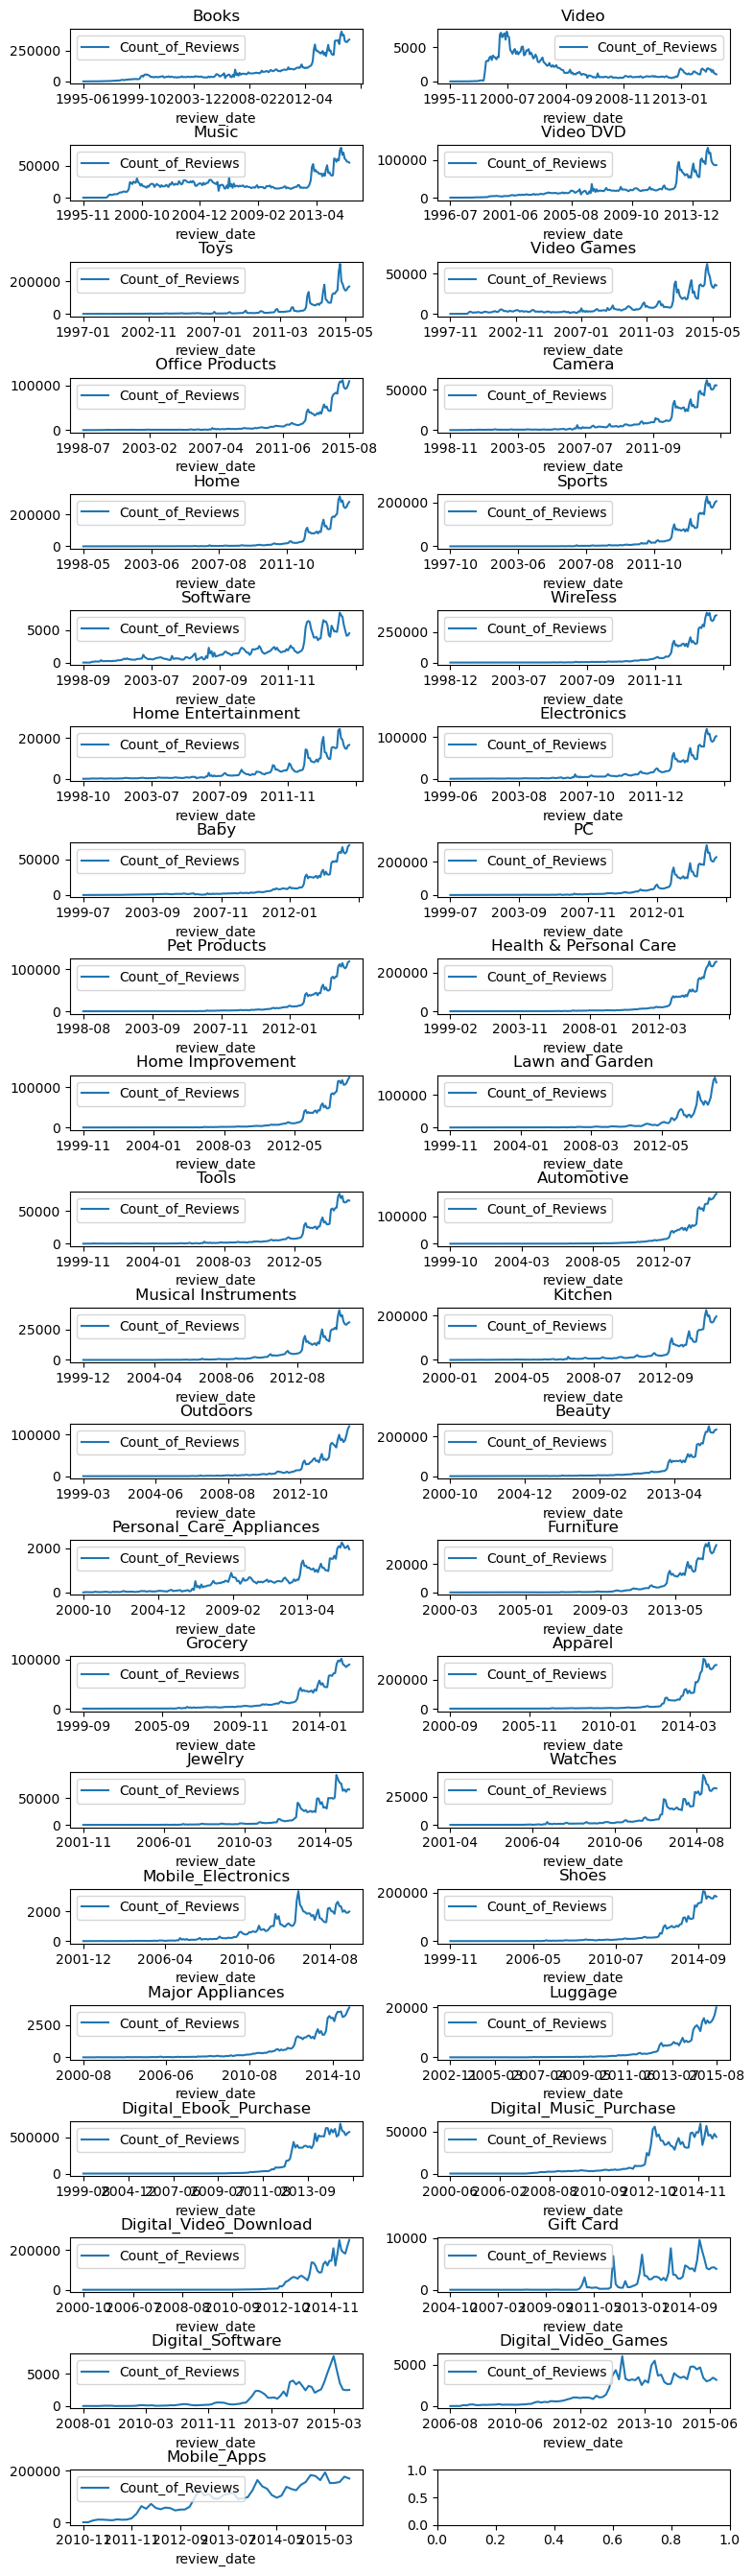

In [23]:
nrow=22
ncol=2

fig, axes = plt.subplots(nrow, ncol, figsize = (8, 27))
fig.tight_layout(pad = 2.5)
# plot counter
counts = 0
for r in range(nrow):
    for c in range(ncol):
        df_list[counts].plot(ax = axes[r,c], title = list_of_products[counts])
        if(counts == 42):
            break
        counts += 1
plt.show()

### Which reviews are getting the most helpful votes / total votes?
#### Any correlation between the length of review headline / review body (in number words) and the "helpfulness" of the review?
##### Ans: No
#### Do you see any correlation between how many reviews a certain customer (customer_id) published and the "helpfulness" of the reviews?
##### Ans: No

In [25]:
df_helpful = df.select(['review_headline', 'helpful_votes'])

In [26]:
df_helpful = df_helpful.withColumn("len_review_headline", length('review_headline'))

In [36]:
df_helpful_pddf = df_helpful.groupby('helpful_votes').agg(avg('len_review_headline')).\
                        withColumnRenamed('avg(len_review_headline)', 'Average_Lenght_of_Review_Headline').\
                        orderBy(['Average_Lenght_of_Review_Headline']).toPandas()

<AxesSubplot:>

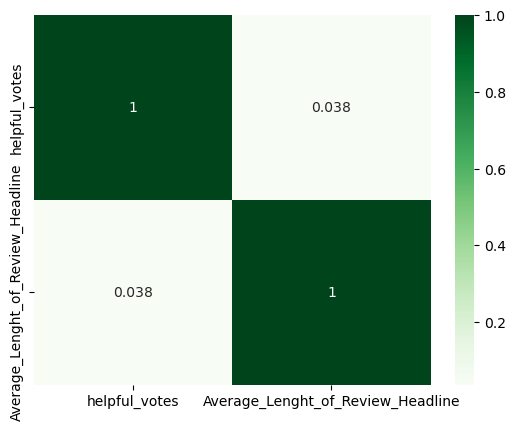

In [28]:
import seaborn as sns
corelation = df_helpful_pddf.corr()
sns.heatmap(corelation, cmap = "Greens", annot=True)

In [29]:
df_helpful_user = df.select(['customer_id', 'helpful_votes', 'review_id'])

In [30]:
df_helpful_user_pddf = df_helpful_user.filter((df_helpful_user.review_id.isNotNull) and (df_helpful_user.review_id != 'NA')).\
                                groupby('customer_id').agg(F.count('review_id'), avg('helpful_votes')).\
                                withColumnRenamed('count(review_id)', 'Count_of_Reviews')

In [33]:
df_helpful_user_pddf.count()
# Too big to convert to a pandas df to create the heatmap

33497620

In [34]:
df_helpful_user_pddf.show(5)

+-----------+----------------+-------------------+
|customer_id|Count_of_Reviews| avg(helpful_votes)|
+-----------+----------------+-------------------+
|   21590081|               4|                0.0|
|   43621192|               6|0.16666666666666666|
|   13622298|               7| 0.5714285714285714|
|    1415660|               1|                0.0|
|   49896642|             123| 1.2682926829268293|
+-----------+----------------+-------------------+
only showing top 5 rows



In [35]:
df_helpful_user_pddf.stat.corr('Count_of_Reviews', 'avg(helpful_votes)')

-0.00018596383909283027